## Anomaly detection


In this problem, you will implement an anomaly detection algorithm to detect
anomalous behavior in server computers. The features measure the throughput
(mb/s) and latency (ms) of response of each server. We have a dataset ${\cal D} = \{x^{(1)}, \ldots, x^{(m)}\}$ of unlabeled examples where 
$m = 307$ and each example $x^{(i)} \in \Re^2$. You suspect that the
vast majority of these examples are “normal” (non-anomalous) examples of
the servers operating normally, but there might also be some examples of
servers acting anomalously within this dataset. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import utils_anomaly

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Anomaly detection on a simple 2D data set
You will use a Gaussian model to detect anomalous examples in your
dataset. You will first start on a 2D dataset that will allow you to visualize
what the algorithm is doing. On that dataset you will fit a Gaussian distribution
and then find values that have very low probability and hence can
be considered anomalies. After that, you will apply the anomaly detection
algorithm to a larger dataset with many dimensions. 

The cell below  will visualize the dataset as shown in Figure 9 of your homework handout.

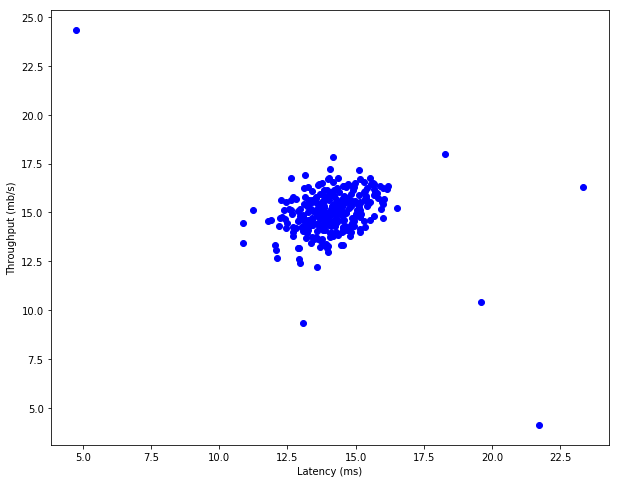

In [2]:
data = scipy.io.loadmat('anomalydata1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

plt.figure()
plt.scatter(X[:,0],X[:,1],c='b')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

## Gaussian distributions
To perform anomaly detection, you will first need to fit a model to the data’s
distribution.
Given a training set $\{x^{(1)}, \ldots, x^{(m)}\}$ (where $x^{(i)} \in \Re^2$), you want to estimate
the Gaussian distribution for each of the features $x_j$. For each feature
$j = 1\ldots d$, you need to find parameters $\mu_j$ and $\sigma_j^2$,
that fit the data in the $j^{th}$ dimension in each example. Recall that a univariate Gaussian distribution is given by
\[ p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}exp\left (-\frac{{(x-\mu)}^2}{2\sigma^2}\right ) \]
where $\mu$ is the mean and $\sigma^2$ is the variance.

### Problem 6.1: Estimating parameters of a Gaussian distribution (5 points)

You can estimate the parameters, $\mu_j$ and $\sigma_j^2$ of the $j^{th}$ feature by using the
following equations. To estimate the mean, you will use:
$$ \mu_j = \frac{1}{m} \sum_{i=1}^{m} x_j^{(i)} $$

To estimate the variance, you will use:

$$ \sigma_j^2 = \frac{1}{m}\sum_{i=1}^{m} {(x_j^{(i)} - \mu_j)}^2 $$

Your task is to complete the function  **estimate_gaussian** in **utils_anomaly.py**. This function
takes as input the data matrix **X** and should output an $d$-dimensional vector
**mu** that holds the mean of all the $d$ features and another $d$-dimensional vector
**var** that holds the variances of all the features. You should implement this
in a  vectorized way to be more efficient.
 Note that in **numpy**, the **var** function will
(by default) use $\frac{1}{m-1}$ instead of $\frac{1}{m}$ when computing $\sigma_j^2$. Use the **ddof** parameter of **numpy.var** and set it to  zero for calculating variance.

Once you have completed the function **estimate_gaussian**, the next
cell of  will visualize the contours of the fitted Gaussian distribution.
 From your plot, you can see that
most of the examples are in the region with the highest probability, while
the anomalous examples are in the regions with lower probabilities.

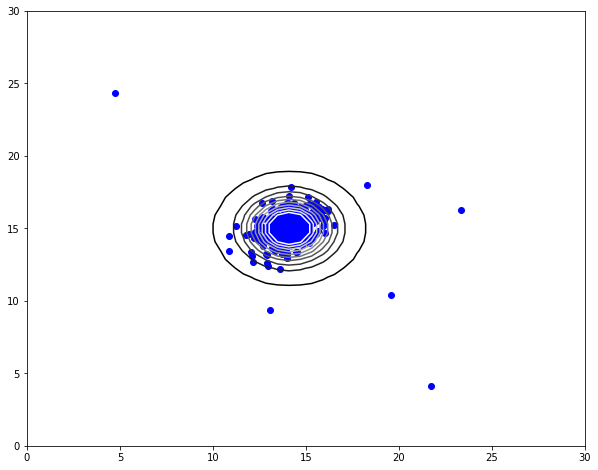

In [3]:
import matplotlib.mlab as mlab
import math
# estimate a Gaussian on the data
mu1, var1 = utils_anomaly.estimate_gaussian(X)

# compute the multivariate normal at each data point of X with these parameters
from scipy.stats import multivariate_normal
p = multivariate_normal.pdf(X,mean=mu1,cov=var1)

# visualize the multivariate normal
plotX,plotY = np.meshgrid(np.linspace(0,30),np.linspace(0,30))
plotZ = mlab.bivariate_normal(plotX,plotY,math.sqrt(var1[0]),math.sqrt(var1[1]),mu1[0],mu1[1])
plt.contour(plotX,plotY,plotZ,levels=[np.mean(plotZ) + i*np.std(plotZ) for i in range(10)])
plt.scatter(X[:,0],X[:,1],c='b')

### Problem 6.2: Selecting the threshold $\epsilon$

Now that you have estimated the Gaussian parameters, you can investigate
which examples have a very high probability given this distribution and which
examples have a very low probability. The low probability examples are
more likely to be the anomalies in our dataset. One way to determine which
examples are anomalies is to select a threshold based on a validation
set. In this part of the assignment, you will implement an algorithm to select
the threshold $\epsilon$ using the F1 score on a validation set.

You should now complete the function **select_threshold** in **utils_anomaly.py**.  For this, we will use a  validation set $\{(x_{v}^{(1)},y_{v}^{(1)}),\ldots,(x_{v}^{(m_{v})},y_{v}^{(m_{v})})\}$, where the label $y_v=1$ corresponds to an anomalous example, and $y_v=0$ corresponds to a normal example. For each example in the validation set, we will compute $p(x_v^{(i)})$. The vector of these probabilities $p(x_v^{(1)}),\ldots, p(x_v^{(m_v)})$ is passed to **select_threshold** function in the vector **pval**. The corresponding set of labels $y_v^{(1)}, \ldots, y_v^{(m_v)}$ is passed to the same function in the vector **yval**.

The function **select_threshold** should return two values; the first is
the selected threshold $\epsilon$. If an example $x$ has a low probability, i.e., $p(x) < \epsilon$,
then it is considered to be an anomaly. The function should also return the
F1 score, which tells you how well you are doing on finding the ground truth
anomalies given a certain threshold. For many different values of $\epsilon$, you will
compute the resulting F1 score by computing how many examples the current
threshold classifies correctly and incorrectly.

The F1 score is computed using precision *prec* and recall *rec*:

$$ F_1 = \frac{2 \times prec \times rec}{prec + rec} $$

You compute precision and recall by:
\begin{eqnarray*}
prec & = & \frac{tp}{tp+fp} \\
rec & = &\frac{tp}{tp+fn}
\end{eqnarray*}
where

- *tp* is the number of true positives: the ground truth label says it is an
anomaly and our algorithm correctly classified it as an anomaly.

- *fp* is the number of false positives: the ground truth label says it is not
an anomaly, but our algorithm incorrectly classified it as an anomaly.

- *fn* is the number of false negatives: the ground truth label says it is an
anomaly, but our algorithm incorrectly classified it as not being anomalous.


In the provided function **select_threshold**, there is already a loop that
will try many different values of $\epsilon$ and select the best $\epsilon$ based on the F1 score.
You need to implement
the computation of the F1 score  over all the 
validation examples (i.e., to compute the values *tp*, *fp*, *fn*). You should see a
value for epsilon of about $8.99*10^{-5}$.

Implementation hints: In order to compute *tp*, *fp* and *fn*, you should
use a vectorized implementation rather than loop over all the
examples. 

Once you have completed the function **select_threshold**, the next cell
will run your function and color the anomalies red in
the contour plot.

8.990852779269493e-05 0.8750000000000001


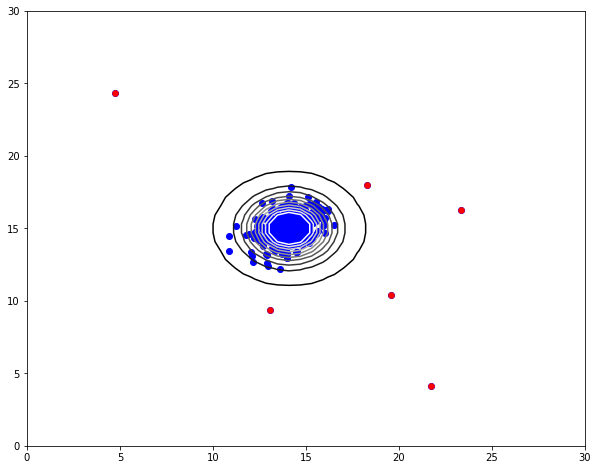

In [4]:
# selecting the anomalous examples using Xval, yval
pval = multivariate_normal.pdf(Xval,mean=mu1,cov=var1)
best_epsilon, F1 = utils_anomaly.select_threshold(yval,pval)
print best_epsilon, F1
outliers = p<best_epsilon
outlier_index = np.array(range(len(outliers)))[outliers]

plotX,plotY = np.meshgrid(np.linspace(0,30),np.linspace(0,30))
plotZ = mlab.bivariate_normal(plotX,plotY,math.sqrt(var1[0]),math.sqrt(var1[1]),mu1[0],mu1[1])
plt.contour(plotX,plotY,plotZ,levels=[np.mean(plotZ) + i*np.std(plotZ) for i in range(10)])
plt.scatter(X[:,0],X[:,1],c='b')
# mark the outliers
plt.scatter(X[outlier_index,0],X[outlier_index,1],c='r',s=30,marker='o')    

## High dimensional dataset
The last cell  of the notebook will run the anomaly detection algorithm
you implemented on a more realistic and much harder dataset. In this
dataset, each example is described by 11 features, capturing many more
properties of the compute servers.
The script will use your functions to estimate the Gaussian parameters,
 evaluate the probabilities for both the training data **X** from which you
estimated the Gaussian parameters, and do so for the the validation
set **Xval**. Finally, it will use **select_threshold** to find the best threshold $\epsilon$.
You should see a value  of about $1.38*10^{-18}$ for $\epsilon$, and 117 anomalies should be found.

In [5]:
# multidimensional outliers
data = scipy.io.loadmat('anomalydata2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']
mu2,var2 = utils_anomaly.estimate_gaussian(X)
p = scipy.stats.multivariate_normal.pdf(X,mean=mu2,cov=var2)
pval = scipy.stats.multivariate_normal.pdf(Xval,mean=mu2,cov=var2)
best_epsilon,bestF1 = utils_anomaly.select_threshold(yval,pval)
print best_epsilon, bestF1
outliers = p<best_epsilon
outlier_index = np.array(range(len(outliers)))[outliers]
print outlier_index.shape

1.3772288907613604e-18 0.6153846153846154
(117,)
